In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 28.2 MB/s 
     |████████████████████████████████| 1.6 MB 63.9 MB/s 
     |████████████████████████████████| 9.3 MB 49.7 MB/s 
     |████████████████████████████████| 108 kB 76.1 MB/s 


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MakingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    return image, label

  def __len__(self):
      return len(self.y)


class TrainTestLoader(object):
  def __init__(self, data_type="CIFAR10"):
    self.data = data_type

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.data == "CIFAR10":
      download_root = "./CIFAR10_DATASET"
      CIFAR10_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = CIFAR10(download_root,
                        train=True,
                        download=True,
                        transform=CIFAR10_transform)

      self.test_data = CIFAR10(download_root,
                        train=False,
                        download=True,
                        transform=CIFAR10_transform)

      train_X = torch.Tensor(self.training_data.data) / 255.0
      train_y = torch.Tensor(self.training_data.targets)

      test_X = torch.Tensor(self.test_data.data) / 255.0
      test_y = torch.Tensor(self.test_data.targets)

      # airplane(index=0), dog(index=5)에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==5)]
      self.train_y = train_y[(train_y==0) | (train_y==5)]
      self.test_X = test_X[(test_y==0) | (test_y==5)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==5)][:1000]

      # airplane은 0으로 dog는 1로 index변환
      self.train_y = torch.where(self.train_y==0, 0, 1)
      self.test_y = torch.where(self.test_y==0, 0, 1)

  def scale_pca(self, n_dim):
    ###여기에 standardscaler 있었는데 그냥 안 함
    if self.data == "CIFAR10":
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2],
                                      train_shape[3]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2],
                                      test_shape[3]))
      train_X_pca =\
                np.zeros((train_shape[0], n_dim, train_shape[3]))
      test_X_pca =\
                np.zeros((test_shape[0], n_dim, test_shape[3]))
      #channel별로 pca적용
      for channel in range(train_shape[-1]):
        pca = PCA(n_components = n_dim)
        # 중요도가 높은 게 아래로 가게 변경
        train_X_pca[:,:,channel] = pca.fit_transform(train_X[:,:,channel])[:,::-1]
        test_X_pca[:,:,channel] = pca.transform(test_X[:,:,channel])[:,::-1]
      self.train_X = torch.Tensor(train_X_pca)
      self.test_X = torch.Tensor(train_X_pca)

  def scale_resize(self, size):
    if self.data == "CIFAR10":
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X_p = self.train_X.permute(0,3,1,2)
      test_X_p = self.test_X.permute(0,3,1,2)
      train_X = t(train_X_p).permute(0,2,3,1)
      test_X = t(test_X_p).permute(0,2,3,1)

      self.train_X = train_X.reshape((train_X.shape[0],
                                     train_X.shape[1]*train_X.shape[2],
                                      train_X.shape[3]))
      self.test_X = test_X.reshape((test_X.shape[0],
                                     test_X.shape[1]*test_X.shape[2],
                                      test_X.shape[3]))

  def return_dataset(self):
      return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)

  # def save(self):
  #     self.training_data.to_csv("./training_data.csv", index = False)
  #     self.test_data.to_csv("./test_data.csv", index = False)

  # def load(self):
  #     self.training_data = read_csv("./training_data.csv")
  #     self.test_data = read_csv("./test_data.csv")



In [ ]:
#QCNN_circuit

class QCNN():
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
    if conv_ansatz == "ConvCirc1":
      self.conv_ansatz = ConvCirc1()
    elif conv_ansatz == "ConvCircSU4":
      self.conv_ansatz = ConvCircSU4()

    if pooling_ansatz == "PoolingCirc":
      self.pooling_ansatz = PoolingCirc()
    
    self.final_ansatz = FinalCirc()

    # self.params = torch.rand(self.Calculate_Param_Num(),
    #                         requires_grad=True)
    self.params = torch.randn(self.Calculate_Param_Num(),
                            requires_grad=True)

  def circuit(self, params, inputs):
    inputs = torch.flatten(inputs.T)
    if self.embedding_type == "Amplitude":
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
    elif self.embedding_type == "HybridAngle_2":
      N = 3  ### 3 classical bits in 2 qubits
      X0_1 = inputs[:N]
      X0_2 = inputs[N:2*N]
      X1_1 = inputs[2*N:3*N]
      X1_2 = inputs[3*N:4*N]
      X2_1 = inputs[4*N:5*N]
      X2_2 = inputs[5*N:6*N]
      self.Angular_Hybrid_2(X0_1, wires=[0,1])
      self.Angular_Hybrid_2(X0_2, wires=[2,3])
      self.Angular_Hybrid_2(X1_1, wires=[4,5])
      self.Angular_Hybrid_2(X1_2, wires=[6,7])
      self.Angular_Hybrid_2(X2_1, wires=[8,9])
      self.Angular_Hybrid_2(X2_2, wires=[10,11])
    elif self.embedding_type == "HybridAngle_4":
      N = 15 # 15 classical data in 4 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      X3 = inputs[2*N:3*N]
      self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
      self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])
      self.Angular_Hybrid_4(X3, wires=[8, 9, 10, 11])

    
    ansatz_param_num = self.conv_ansatz.num_params
    final_ansatz_param_num = self.final_ansatz.num_params
    #circuit0 parameters
    param0_1 = params[0, 0:ansatz_param_num]
    param0_2 = params[0, ansatz_param_num: 2 * ansatz_param_num]

    param0_3 = params[0, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param0_4 = params[0, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]

    #circuit1 parameters
    param1_1 = params[1, 0:ansatz_param_num]
    param1_2 = params[1, ansatz_param_num: 2 * ansatz_param_num]

    param1_3 = params[1, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param1_4 = params[1, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]

    #circuit2 parameters
    param2_1 = params[2, 0:ansatz_param_num]
    param2_2 = params[2, ansatz_param_num: 2 * ansatz_param_num]

    param2_3 = params[2, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param2_4 = params[2, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]

    #circuit3 - final circuit parameters
    final_param = params[2 * ansatz_param_num + 4 : final_ansatz_param_num]

    self.conv_layer1(param0_1,param1_1,param2_1)
    self.pooling_layer1(param0_3, param1_3, param2_3)

    self.conv_layer2(param0_2, param1_2, param2_2)
    self.pooling_layer2(param0_4, param1_4, param2_4)

    self.final_layer(final_param)


  # Hybrid Angle Embedding
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])


  # Convolutional layers
  def conv_layer1(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.conv_ansatz.apply(parameter, wires=[0+ch, 1 + ch])
      self.conv_ansatz.apply(parameter, wires=[2+ch, 3 + ch])
      self.conv_ansatz.apply(parameter, wires=[0+ch, 3 + ch])
      self.conv_ansatz.apply(parameter, wires=[1+ch, 2 + ch])

  def conv_layer2(self,  params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.conv_ansatz.apply(parameter, wires=[1+ch, 3+ch])


  # Pooling layers
  def pooling_layer1(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.pooling_ansatz.apply(parameter, wires=[0+ch, 1+ch])
      self.pooling_ansatz.apply(parameter, wires=[2+ch, 3+ch])

  def pooling_layer2(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.pooling_ansatz.apply(parameter, wires=[1+ch, 3+ch])
  
  #fianly layer - 3개의 채널에서 나온 결과를 종합
  def final_layer(self, final_param):
    self.final_ansatz.apply(final_param, wires = [3, 7, 11])


  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return total_param_num


# def estimated_label(params, data):
#     return circuit(params, data) 



In [ ]:
## ansatz 여기에서 추가 가능

# Convolutional Layer Ansatz
class ConvCirc1():
  def __init__(self) -> None:
    self.num_params = 2

  def apply(self, weights, wires):
    qml.RY(weights[0], wires = wires[0])
    qml.RY(weights[1], wires = wires[1])
    qml.CNOT(wires = wires)

# Convolutional Layer Ansatz SU(4)
class ConvCircSU4():

  def __init__(self) -> None:
      self.num_params = 15

  def apply(self, weights, wires):
      qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
      qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.RY(weights[6], wires = wires[0])
      qml.RZ(weights[7], wires = wires[1])
      qml.CNOT(wires = [wires[1], wires[0]])
      qml.RY(weights[8], wires=wires[0])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.U3(weights[9], weights[10], weights[11], wires = wires[0])
      qml.U3(weights[12], weights[13], weights[14], wires = wires[1])

# Pooling Layer Ansatz
class PoolingCirc():
    def __init__(self) -> None:
        self.num_params = 2
    
    def apply(self, weights, wires):
        qml.CRY(weights[0], wires = wires)
        qml.PauliX(wires[0])
        qml.CRY(weights[1], wires = wires)
        qml.PauliX(wires[0])



In [ ]:
class Setting():
  def __init__(self, n_qubits=8, data_type="MNIST",
               scaling_method = "pca",
               scaled_dim = 256, EPOCHS = 3, train_iter = 200,
               BATCH_SIZE = 25, LEARNING_RATE = 0.01, VAL_SIZE = 1000,
               conv_ansatz="ConvCirc1", pooling_ansatz="PoolingCirc",
               criterion = nn.MSELoss()):
    self.n_qubits=n_qubits
    self.data_type=data_type
    self.scaling_method = scaling_method
    self.scaled_dim = scaled_dim
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.VAL_SIZE = VAL_SIZE
    self.conv_ansatz=conv_ansatz
    self.pooling_ansatz=pooling_ansatz
    self.criterion = criterion

    loader = TrainTestLoader(data_type=data_type)
    if self.scaling_method == "pca":
      loader.scale_pca( n_dim = scaled_dim)
    elif self.scaling_method == "resize":
      loader.scale_resize( size=scaled_dim )
    self.train_data, self.test_data = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_data)}")
    # print(f"Validation set #: {len(validation_set)}")
    print(f"Test set #:  {len(self.test_data)}")

    #######################file path 필요하면 수정######################
    self.filepath = "/content/drive/MyDrive/박경덕교수님연구실/MY_QCNN_module_ver" +\
            "/"+conv_ansatz+"_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz)

  def make_optimizer(self, param):
    return optim.Adam([param], lr = self.LEARNING_RATE)

  def make_train_loader(self):
    return DataLoader(self.train_data, batch_size = self.BATCH_SIZE, shuffle=True)

  def make_test_loader(self):
    return DataLoader(self.test_data, batch_size = len(self.test_data), shuffle=False)




In [ ]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.avg_vloss_list = []
    self.history_of_parameters = []
    self.total_time = None

  # iter mode
  def training_model(self, model, train_loader)->None:
    optimizer = self.setting.make_optimizer(model.params)
    start_t = time.time()
    for iter, data in enumerate(train_loader):
      if iter == self.setting.train_iter:
        break

      inputs, labels = data
      labels = 2*labels.to(torch.float64) - 1 # label을 1과 -1로 변환
      optimizer.zero_grad()
      loss = torch.tensor(0, dtype = torch.float64)
      for input, label in zip(inputs, labels):
        pred = estimated_label(model.params, input)
        loss += self.setting.criterion(pred, label) / len(labels)
      loss.backward()
      optimizer.step()
      self.loss_list.append(loss.item())
      self.setting.writer.add_scalar('training loss', loss.item(), iter)
      np.save(self.setting.filepath+'/'+f'iter{iter}', params.detach().numpy())
      if (iter+1)%10 == 0:
        print(f"Iteration {iter+1:>3} loss: {loss.item()}")
    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")


# epoch mode



In [ ]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0
  
  def testing_model(self, model, test_loader)->None:
    with torch.no_grad():
      pred_label_arr = []
      true_label_arr = []
      for inputs, labels in test_loader:
        for input, label in zip(inputs, labels):
          pred = estimated_label(model.params,input) > 0
          pred_label_arr.append(pred)
          true_label_arr.append(label.numpy())
      accuracy = sum(np.array(pred_label_arr)==\
                 np.array(true_label_arr))  /  len(true_label_arr)
      self.accuracy = accuracy.numpy()
      print(f"Test socre: {self.accuracy}")



In [ ]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)



In [ ]:
########################## hyper param ##############################
n_qubits = 8
data_type = "MNIST"
scaling_method = "resize"  #### "pac" or "resize" ####
scaled_dim = 256
EPOCHS = 3
train_iter = 200
BATCH_SIZE = 25
LEARNING_RATE = 0.01
VAL_SIZE = 1000

conv_ansatz="ConvCircSU4" #### "ConvCirc1", "ConvCircSU4"
pooling_ansatz="PoolingCirc"
criterion = nn.MSELoss()

########################## hyper param ##############################


setting = Setting(n_qubits=n_qubits,
                  data_type=data_type,
                  scaling_method = scaling_method,
                  scaled_dim = scaled_dim,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  VAL_SIZE = VAL_SIZE,
                  conv_ansatz=conv_ansatz,
                  pooling_ansatz=pooling_ansatz,
                  criterion = criterion)

train_loader = setting.make_train_loader()
test_loader = setting.make_test_loader()

model = setting.make_model()
dev = qml.device("default.qubit", wires=setting.n_qubits)
@qml.qnode(dev, interface="torch")
def qnode(params, inputs):
  model.circuit(params,inputs)
  return qml.expval(qml.PauliZ(3))

def estimated_label(params, inputs):
  return qnode(params, inputs)


Train set #: 12665
Test set #:  1000


In [ ]:
init_param = model.params
print( init_param )

tensor([ 0.6547,  0.5760, -0.3609, -0.0606,  0.0733,  0.8187,  1.4805,  0.3449,
        -0.6867,  0.6368,  0.2176, -0.0467, -1.4335, -0.5665, -0.4253,  0.2625,
        -0.7328,  0.1043,  1.0414, -0.3997, -2.2933,  0.4976, -0.4257, -1.3371,
        -1.1955,  0.8123, -0.3063, -0.3302, -0.9808,  0.1947, -1.6535,  0.6814,
         0.1748, -1.0939,  0.9633,  1.5335, -1.4510, -0.7861, -0.9563, -1.2476,
        -0.7499, -0.5922,  1.7744, -0.7251,  0.4664,  0.6667, -0.0439,  0.2368,
        -0.7061, -0.7169,  0.5261], requires_grad=True)


In [ ]:
setting.train_data[0][1]

tensor(0)

In [ ]:
img = setting.train_data[0][0].reshape(16,16)

In [ ]:
img.numpy().shape

(16, 16)

In [ ]:
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(img, cmap='gist_yarg')
  plt.show()




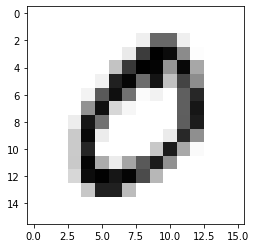

In [ ]:
custom_imshow(img)

In [ ]:
############ train model ###########

trainer = Trainer(setting = setting)
trainer.training_model(model=model, train_loader=train_loader)

Iteration  10 loss: 0.9572932120675457
Iteration  20 loss: 0.841245641948781
Iteration  30 loss: 0.7620210061049894
Iteration  40 loss: 0.6999579810969735
Iteration  50 loss: 0.6315967810271986
Iteration  60 loss: 0.5984308834945234
Iteration  70 loss: 0.5625138246848289
Iteration  80 loss: 0.5576412036841963
Iteration  90 loss: 0.5676188369923102
Iteration 100 loss: 0.5343583660147412
Iteration 110 loss: 0.5074388777252543
Iteration 120 loss: 0.5671166456487193
Iteration 130 loss: 0.49053997726776616
Iteration 140 loss: 0.5418372158518194
Iteration 150 loss: 0.4790601086998001
Iteration 160 loss: 0.49765942755003495
Iteration 170 loss: 0.4488420911020666
Iteration 180 loss: 0.49859935047194115
Iteration 190 loss: 0.4902170511537633
Iteration 200 loss: 0.5038307729127999
Training during 200 iterations finishes (taken time: 0:18:43) 


In [ ]:
after_param = model.params
print( after_param )

tensor([ 2.0945,  1.7033,  1.2298, -2.7897,  0.5078, -0.5463,  0.0219, -2.0893,
        -0.6004,  1.4639, -0.4732, -1.4961, -0.6577, -0.4343, -1.2177,  0.6583,
         1.7593,  0.1560, -0.8890,  0.5395, -0.7724,  1.5177,  1.2256,  1.5938,
         0.8699,  0.5550,  0.1708,  1.3521, -0.6184,  0.0931, -0.3637,  0.9885,
        -1.0410, -0.7199, -0.4287,  0.5475, -0.3439,  0.6696, -0.8891, -0.4166,
        -0.8539, -0.8544,  1.4723,  0.6890,  0.2192,  0.9892, -0.0851,  1.1369,
        -0.6948,  0.7914, -0.8084], requires_grad=True)


In [ ]:
############# test model ###############

tester = Tester(setting = setting)
tester.testing_model(model, test_loader)


Test socre: 0.994


In [ ]:
saving_summary(setting, trainer, tester)

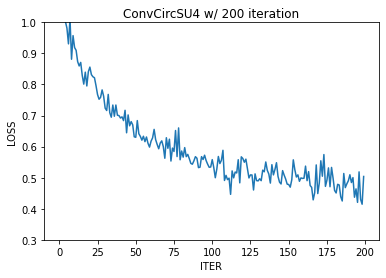

In [ ]:
############### loss plot ################

# loss_list
plt.plot(trainer.loss_list)
plt.title(f"{setting.conv_ansatz} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.3, 1.0))

plt.show()


In [ ]:
####### tensorboard 실행 #######
!tensorboard --logdir=filepath+"/"

2022-08-14 06:24:05.865481: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
